# 1. Problem Statement

We want to solve the one-dimensional transport equation

$$
\frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x} = 0
$$

subject to the boundary conditions:

- $u(0, t) = k_1, \quad t \ge 0$,
- $u(x, 0) = k_2, \quad x \ge 0$,

where $c > 0$ is a constant transport (or wave) speed. We assume $k_1$ and $k_2$ are constants.

This PDE and boundary conditions have been chosen as a simple model for the Buckley-Leverett equation solved in your assignment.

---


# 2.  Analytical Solution

The PDE above can be analytically solved via the *method of characteristics*. 

I'll just quote the solution for now, but if interested we can go through the solution in more detail.

$$
u(x,t) = 
\begin{cases}
k_1, & x < c\,t,\\
k_2, & x \ge c\,t.
\end{cases}
$$

---

## Discretization

We introduce a uniform spatial grid given by 
$$x_i = i \,\Delta x,\quad i=0,1,\ldots,N,$$ 
and a uniform time grid given by 
$$t^n = n\,\Delta t,\quad n=0,1,\ldots,M.$$ 

At each grid point, we store an approximation (a `float`)
$$u_i^n \approx u\bigl(x_i, t^n\bigr).$$

To discretize the PDE 
$$
\frac{\partial u}{\partial t} + c \,\frac{\partial u}{\partial x} = 0
$$ 
for a right-moving transport ($c>0$), we use:

- A forward difference for the time derivative:
  $$
  \frac{\partial u}{\partial t}\bigg|_{i} 
  \approx \frac{u_i^{n+1} - u_i^n}{\Delta t}.
  $$
- A **left (upwind) difference** for the spatial derivative:
  $$
  \frac{\partial u}{\partial x}\bigg|_{i} 
  \approx \frac{u_i^n - u_{i-1}^n}{\Delta x}.
  $$
  
This choice of “upwind” derivative is appropriate for $c>0$ because the wave travels from left to right. 

---


# Numerical Scheme

We'll use a finite difference approximation on the uniform grids $x_i = i\,\Delta x$ 
and $t^n = n\,\Delta t$.

Define $u_i^n \approx u(x_i, t^n)$. For $c > 0$, an explicit "upwind" scheme is:

$$
u_i^{n+1} = u_i^n - \lambda \bigl( u_i^n - u_{i-1}^n \bigr),
$$

where 

$$
\lambda = \frac{c\,\Delta t}{\Delta x}.
$$

**Stability constraint**: To ensure numerical stability for this explicit scheme, 
we require $\lambda \le 1$, i.e.

$$
\Delta t \le \frac{\Delta x}{c}.
$$

**Implementing boundary/initial conditions**:
- For $x=0$ (i.e. $i=0$), at every time step $t^n$, we set $u_0^n = k_1$.
- For $t=0$ (i.e. $n=0$), for all $i$, we set $u_i^0 = k_2$.

---

# Implementing in Code 

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [10]:
# ------------------------
# 1) Parameters & Setup
# ------------------------

c = 1.0                     # wave speed
k1 = 1.0                    # boundary condition at x = 0, for all t > 0
k2 = 2.0                    # initial condition at t = 0, for all x > 0

x_max = 4                   # spatial domain: 0 <= x <= x_max
nx = 101                    # number of spatial grid points
dx = x_max / (nx - 1)
t_max = 2.0                 # final time
dt = 0.8 * dx/c             # time step (satisfies stability criterion)
nt = int(t_max/dt) + 1      # number of time steps

# Create the grid
x = np.linspace(0, x_max, nx)

In [11]:
# ------------------------
# 2) Initial Condition
# ------------------------

# Array for solution u
u = np.zeros(nx)
# At t=0, u(x,0) = k2
u[:] = k2

# Enforce boundary at x=0 for t=0
u[0] = k1

In [ ]:
# ------------------------
# 3) Approximating forward in time using numerical scheme
# ------------------------

for n in range(nt):
    u_new = u.copy()
    # Enforce boundary condition at x=0 for this time step
    u_new[0] = k1
    
    # Upwind update for interior points
    for i in range(1, nx):
        u_new[i] = u[i] - (c*dt/dx) * (u[i] - u[i-1])
    
    u = u_new # Overwrite old timestep

In [13]:
# ------------------------
# 4) Analytical Solution
# ------------------------

# We'll compare at the final time t_final
t_final = nt * dt

# The exact solution at x is k1 if x < c*t_final, otherwise k2
u_exact = np.where(x < c * t_final, k1, k2)

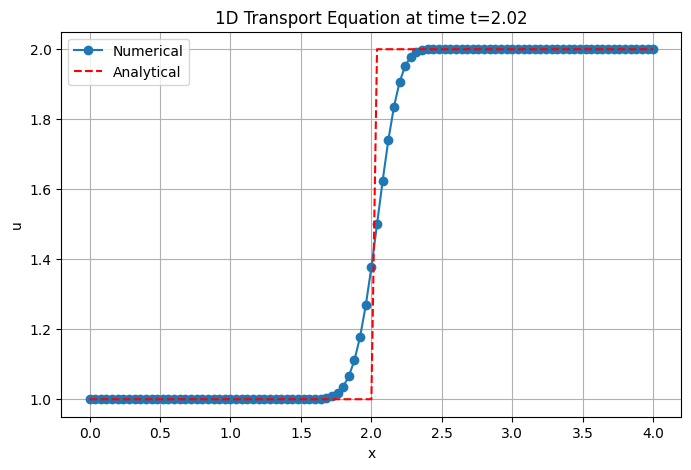

In [14]:
# ------------------------
# 5) Plot Results
# ------------------------

plt.figure(figsize=(8,5))
plt.plot(x, u, 'o-', label='Numerical')
plt.plot(x, u_exact, 'r--', label='Analytical')
plt.title(f"1D Transport Equation at time t={t_final:.2f}")
plt.xlabel("x")
plt.ylabel("u")
plt.grid(True)
plt.legend()
plt.show()


## Exercise 1a - Modular Solver

In this exercise, you’ll refactor the code that solves the linear transport equation
$$
\frac{\partial u}{\partial t} + c \,\frac{\partial u}{\partial x} = 0
$$
into a more modular design. You’ll create:

1. **A solver function** to run the time stepping.

2. **Storage** for intermediate solutions at various time levels.

3. **A way to compare** the numeric solution against the analytical one at some specified snapshot times.


 --

**Key Point**: The challenge is that your time‐stepping loop will generally land on discrete times 
$$
t^0 = 0,\, t^1 = \Delta t,\, t^2 = 2\,\Delta t,\,\ldots
$$
which may **not** match exactly your desired snapshot times 
$$
t_\text{snap} \in \{\dots\}.
$$
So you’ll need a strategy to store the solution at all time steps, then retrieve the “closest” time step for each desired snapshot.

### Suggested Steps

1. **Implement a solver** that initializes $u$ on a spatial grid, then iterates through time:
   - Use the upwind finite difference scheme for \(c>0\).
   - Store **all** solutions at each time step in a list or array (so you can extract them later).
   
2. **Define a function or method** that, given a list of times and corresponding solutions, finds the nearest time indices to the specified “snapshot times.” This could be:
   ```python
   def get_nearest_time_index(target_time, time_array):
       # returns the index i such that time_array[i] is closest to target_time


In [ ]:
def transport_solver(c, k1, k2, x_max, nx, dt, t_max):
    """
    Solve the 1D linear transport equation:
        partial_t u + c partial_x u = 0
    with boundary condition u(0,t) = k1 and initial condition u(x,0) = k2,
    using the upwind scheme for c > 0.
    
    Parameters
    ----------
    c : float
        Transport velocity (c > 0).
    k1 : float
        Boundary condition at x=0.
    k2 : float
        Initial condition for x > 0.
    x_max : float
        Maximum spatial domain length (0 <= x <= x_max).
    nx : int
        Number of spatial grid points.
    dt : float
        Time step size (must satisfy stability: c*dt <= dx).
    t_max : float
        Final time to run the solver.
    
    Returns
    -------
    x : ndarray of shape (nx,)
        Spatial grid points.
    times : ndarray of shape (nt+1,)
        The times at which the solution was stored.
    solutions : list of ndarrays
        Each entry solutions[n] is the solution array u at time times[n].
    """
    
    # TODO: Create the spatial grid x
    # x = ...
    dx = x_max / (nx - 1)
    
    # TODO: Determine number of time steps nt from dt and t_max (use int(t_max / dt))
    # nt = ...
    
    # Initialize time array
    # times = np.arange(nt+1) * dt
    # (This includes t=0 up to the final time step.)
    
    # Create initial condition array
    # u = ...
    
    # Overwrite boundary condition at x=0
    # u[0] = ...
    
    # Create a list to store solutions at each time
    # solutions = []
    # solutions.append(u.copy())
    
    # Time stepping
    # for n in range(nt):
    #     # Create a copy of u to hold the updated values
    #     u_new = u.copy()
    #
    #     # Enforce boundary condition at x=0
    #     u_new[0] = k1
    #
    #     # Upwind update for i in [1, nx-1]
    #     # for i in range(1, nx):
    #         # u_new[i] = ...
    #
    #     # Update u
    #     u = u_new
    #     # Store the new solution
    #     solutions.append(u.copy())
    
    # return x, times, solutions


def get_nearest_time_index(target_time, time_array):
    """
    Returns the index i such that time_array[i] is closest to target_time.
    """
    # TODO: implement a simple search or use numpy functionality
    return 0  # placeholder


def analytical_solution(x, t, c, k1, k2):
    """
    Compute the piecewise analytical solution at time t for x >= 0, c>0,
    boundary condition u(0,t)=k1, initial condition u(x,0)=k2.
    """
    # TODO: implement the piecewise definition
    # if x < c t => k1, else k2
    return None  # placeholder


def plot_snapshots(x, times, solutions, c, k1, k2, snap_times):
    """
    Plot the numerical and analytical solutions at each time in snap_times.
    Uses get_nearest_time_index to find the stored times that are closest to
    each desired snapshot time.
    
    Parameters
    ----------
    x : ndarray
        The spatial grid.
    times : ndarray
        All times for which we have stored the numeric solutions.
    solutions : list of ndarrays
        solutions[n] is the numeric solution at times[n].
    c, k1, k2 : floats
        PDE / boundary parameters.
    snap_times : list of floats
        The times at which we want to compare numeric to analytic solutions.
    """
    plt.figure(figsize=(8,6))

    for t_snap in snap_times:
        # 1) Find nearest stored time index
        idx = get_nearest_time_index(t_snap, times)
        
        # 2) Retrieve numeric solution
        u_num = solutions[idx]
        
        # 3) Compute exact solution
        u_exact = analytical_solution(x, times[idx], c, k1, k2)
        
        # 4) Plot
        plt.plot(x, u_num, label=f"Numeric (t={times[idx]:.3f})")
        plt.plot(x, u_exact, '--', label=f"Exact (t={times[idx]:.3f})")
    
    plt.xlabel("x")
    plt.ylabel("u")
    plt.title("Snapshots of the Transport Equation Solution")
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


In [1]:
x, times, solutions = transport_solver(c=1.0, 
                                       k1=1.0, 
                                       k2=2.0,
                                       x_max=2.0, 
                                       nx=101,
                                       dt=0.001, 
                                       t_max=1.0)

plot_snapshots(x, times, solutions, c=1.0, k1=1.0, k2=2.0,
               snap_times=[0.0, 0.25, 0.5, 1.0])


NameError: name 'transport_solver' is not defined

## Exercise 1b: Exploring the Stability Condition

Using the **solver** and **plotting functions** you wrote in Exercise 1a, investigate how changing the time step $ \Delta t $ affects the quality and stability of the numerical solution. In particular:

1. **Pick a fixed spatial grid** (e.g., $ x_{\max} = 2.0 $ with 101 points) and a wave speed $ c = 1.0 $.
2. **Run your solver** three times with different time steps:
   - $ \Delta t_1 = 0.8 \cdot \frac{\Delta x}{c} $
   - $ \Delta t_2 = 1.0 \cdot \frac{\Delta x}{c} $
   - $ \Delta t_3 = 1.2 \cdot \frac{\Delta x}{c} $ 
3. **Plot and compare** the final numerical solutions (at the same $ t_{\max} $, e.g., 1.0) to the analytical solution. For each run, try plotting one or more snapshots to observe whether the scheme remains stable or if numerical oscillations/growth occur.


# Buckley–Leverett: A Variable Velocity $c(u)$

In the Buckley–Leverett equation, the “wave speed” is no longer a constant \(c\), but rather **a function of the solution** \(u\). That is, instead of  
$$
\frac{\partial u}{\partial t} + c \,\frac{\partial u}{\partial x} = 0,
$$
we might have  
$$
\frac{\partial u}{\partial t} + c(u)\,\frac{\partial u}{\partial x} = 0.
$$

Equivalently, this can be written in conservation-law form:
$$
\frac{\partial u}{\partial t} + \frac{\partial}{\partial x}\bigl[f(u)\bigr] = 0,
\quad \text{where} \quad f'(u) = c(u).
$$

In Buckley–Leverett, the flux function \(f\) depends on fractional-flow properties, leading to a **non-constant** wave speed for discontinuities. Below, you will adapt your linear solver to one with a **variable velocity** \(c(u)\). This is a stepping stone to the fully nonlinear Buckley–Leverett problem.

---

## Exercise 2: Adapting the Solver for a Variable Velocity

**Goal**: Extend your **upwind** solver so that, at each grid cell, the velocity is \(c\bigl(u_i^n\bigr)\) instead of a constant \(c\).

### Suggested PDE Setup

Consider:
$$
\frac{\partial u}{\partial t} + c\bigl(u\bigr)\,\frac{\partial u}{\partial x} = 0,
$$
with a chosen function, for example,
$$
c(u) = \frac{1}{1 + u^{0.3}},
$$
and boundary/initial conditions that remain
$$
u(0,t) = 1, \quad u(x,0) = 2, \quad \text{for} \; x \ge 0, \, t \ge 0.
$$

### Implementation Hints

1. **Local Velocity**: At each grid cell, the velocity is 
\(
c_i^n = c\bigl(u_i^n\bigr).
\)
2. **Upwind Update** (assuming \(c_i^n > 0\)): 
$$
u_i^{n+1} \;=\; u_i^n \;-\; \lambda_i\,\bigl[u_i^n - u_{i-1}^n\bigr],
$$
where 
$$
\lambda_i = \frac{c\bigl(u_i^n\bigr)\,\Delta t}{\Delta x}.
$$
3. **Stability Constraint**: You need 
\(
\max_i \bigl[c(u_i^n)\bigr] \le \frac{\Delta x}{\Delta t},
\)
so choose \(\Delta t\) accordingly.
4. **Analytical Solution**: For **non-constant** velocity, a closed-form solution might not be trivial. You can still:
   - Compare solutions at different \(\Delta t\) or \(\Delta x\) values.
   - Observe whether the wave front moves consistently with your expectations.

### Task

- **Create or modify** a solver function to incorporate \(c(u)\) in each cell.
- **Plot** several snapshots of the numerical solution (like in previous exercises).
- **Check** if the method remains stable and if any numerical diffusion or spurious oscillations appear.

By making this change, you have taken the first step from a **linear** to a **nonlinear** advection problem. That is exactly how you go from a simple transport equation toward the Buckley–Leverett model in more advanced reservoir simulations.
